In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseimedvedev","key":"e7e2e8ad9f177293686bb5c420c22c41"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d marquis03/plants-classification

100% 1.34G/1.34G [00:34<00:00, 43.8MB/s]
100% 1.34G/1.34G [00:34<00:00, 41.2MB/s]


In [ ]:
! unzip '/content/plants-classification.zip' -d '/content/plants-classification'

In [6]:
datadir='/content/plants-classification'
traindir='/content/plants-classification/train'
testdir='/content/plants-classification/test'
valdir='/content/plants-classification/val'

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [9]:
train_transform = v2.Compose([v2.Resize([224,224]),v2.RandomHorizontalFlip(0.25),
                              v2.RandomRotation(5),
                              v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
transform = v2.Compose([v2.Resize([224,224]), v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True)])

In [10]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=transform)
val_dataset=datasets.ImageFolder(valdir,transform=transform)

In [11]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

In [12]:
lb=train_dataset.targets
lb=np.array(lb)
np.unique(lb,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700,
        700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700,
        700, 700, 700, 700]))

In [13]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

torch.Size([32, 3, 224, 224])


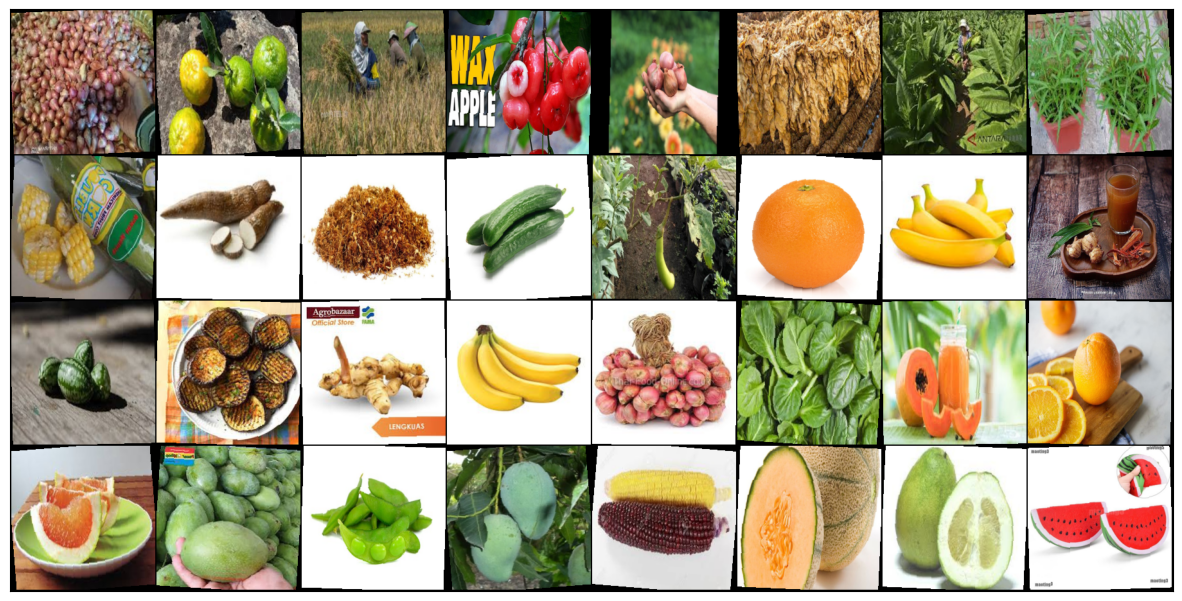

In [14]:
show_batch(train_loader)

torch.Size([32, 3, 224, 224])


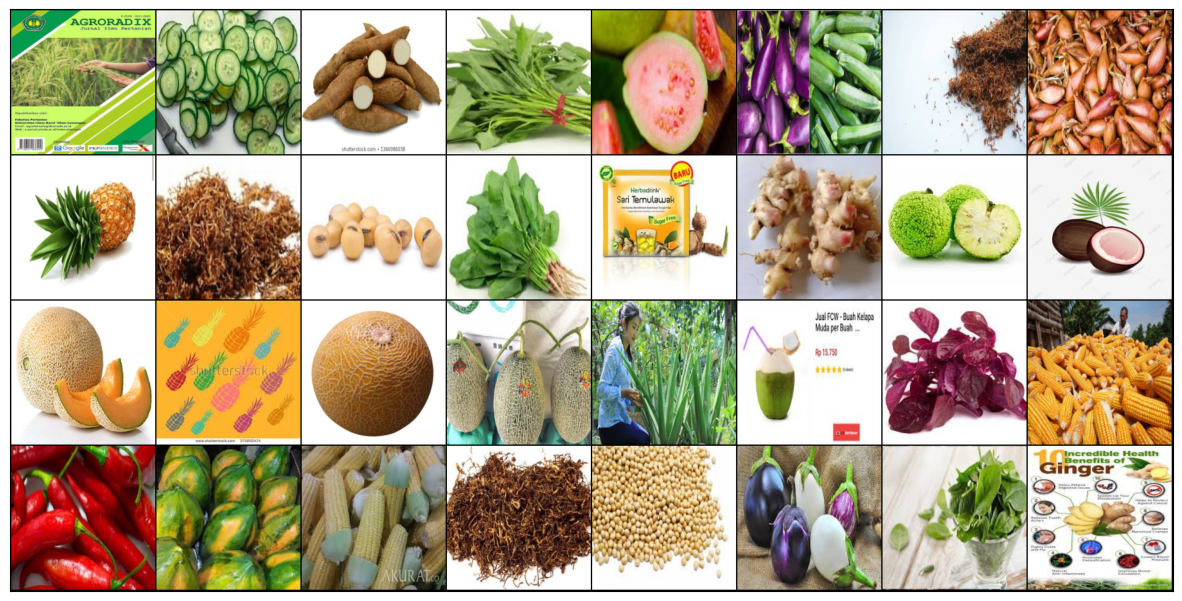

In [15]:
show_batch(test_loader)

In [16]:
import torchvision.models as models

In [ ]:
! pip install efficientnet_pytorch

In [26]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
model.to(device);

Loaded pretrained weights for efficientnet-b0


In [19]:
! pip install torchinfo

In [27]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 1000]                 --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 112, 112]         864
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

In [28]:
num_cls=len(train_dataset.classes)

In [29]:
model._fc=nn.Linear(1280,num_cls)

In [30]:
model.to(device);

In [31]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 30]                   --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 112, 112]         864
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

In [32]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [33]:
!pip install pytorch-ignite --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 5.8 MB/s eta 0:00:00


In [34]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [35]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [36]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=num_cls)}

In [37]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [38]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [39]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [40]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(val_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [41]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [42]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [43]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.10/dist-packages/ignite/contrib/handlers/tqdm_logger.py:126: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [44]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  0%|          | 1/657 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 79.89 Сред. ошибка: 0.62907
Результат валидации - Эпоха: 1  Сред. точность: 79.37 Сред. ошибка: 0.66240


  0%|          | 1/657 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 86.50 Сред. ошибка: 0.40614
Результат валидации - Эпоха: 2  Сред. точность: 82.90 Сред. ошибка: 0.58940


  0%|          | 1/657 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 89.15 Сред. ошибка: 0.30708
Результат валидации - Эпоха: 3  Сред. точность: 85.20 Сред. ошибка: 0.50030


  0%|          | 1/657 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 88.62 Сред. ошибка: 0.31587
Результат валидации - Эпоха: 4  Сред. точность: 82.33 Сред. ошибка: 0.57604


  0%|          | 1/657 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 89.48 Сред. ошибка: 0.28993
Результат валидации - Эпоха: 5  Сред. точность: 83.83 Сред. ошибка: 0.58310


State:
	iteration: 3285
	epoch: 5
	epoch_length: 657
	max_epochs: 5
	output: 0.1578829288482666
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

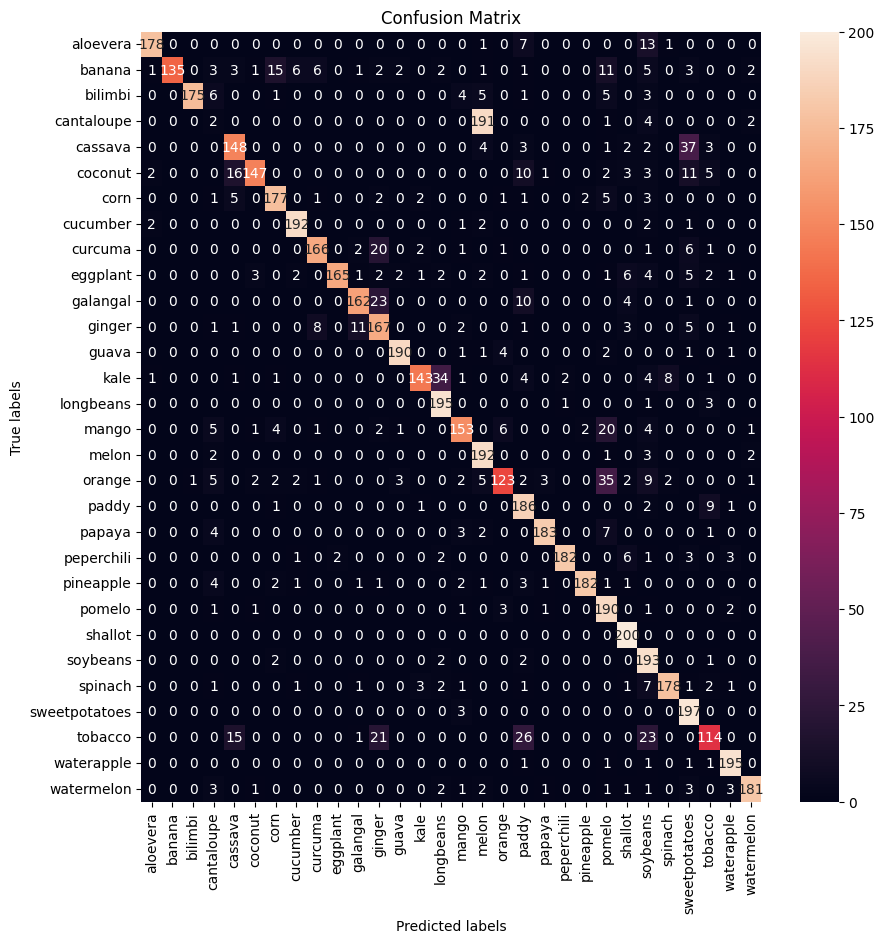

In [45]:
trainer.run(train_loader, max_epochs=5)